# Bitcoin News Sentiment Analysis Example

This notebook demonstrates an end-to-end workflow for analyzing Bitcoin news sentiment, visualizing the results, and customizing the analysis for different cryptocurrencies.

## Overview

This example shows how to:
1. Configure API keys and providers
2. Fetch Bitcoin news articles
3. Analyze sentiment using different LLM providers
4. Visualize sentiment trends
5. Export results to CSV
6. Customize for different cryptocurrencies

## 1. Setup and Installation

First, install the required packages:

In [12]:
# Install required packages
%pip install -q pandas matplotlib plotly requests python-dotenv litellm tiktoken

Note: you may need to restart the kernel to use updated packages.


## 2. Configuration

Set up environment variables and configuration. For this example, we need:
- NEWS_API_KEY (required)
- At least one LLM provider API key (OPENAI_API_KEY, TOGETHER_API_KEY, etc.)

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from dotenv import load_dotenv
import json
from datetime import datetime, timedelta
import numpy as np
import random

# Create data directory if it doesn't exist
data_dir = Path.cwd() / "data"
data_dir.mkdir(exist_ok=True)

# Load environment variables
load_dotenv()

# Check if we have the required API key
if not os.getenv("NEWS_API_KEY"):
    print("⚠️ WARNING: NEWS_API_KEY not found in .env file")
    print("You should create a .env file with your API keys:")
    print("NEWS_API_KEY=your_newsapi_key")
    print("OPENAI_API_KEY=your_openai_key  # optional")
    print("TOGETHER_API_KEY=your_together_key  # optional")
    # For demo purposes, we'll skip the API calls and work with sample data
    DEMO_MODE = True
else:
    DEMO_MODE = False
    print("✅ API keys loaded successfully")

✅ API keys loaded successfully


## 3. Import Utilities

Now let's import the utility functions from `bitcoin_utils.py`. If we're in demo mode, we'll create some sample data for demonstration.

In [14]:
if not DEMO_MODE:
    # Import our actual utility functions
    try:
        from bitcoin_utils import (
            Config, fetch_bitcoin_news, classify_sentiment,
            process_news_articles, make_clickable, create_sentiment_pie_chart
        )
        config = Config.load()
        print(f"Using LLM provider: {config.PROVIDER}")
    except ImportError:
        print("Could not import bitcoin_utils. Using DEMO_MODE instead.")
        DEMO_MODE = True

# For demo mode, create sample data
if DEMO_MODE:
    print("Running in DEMO_MODE with sample data")
    
    # Create sample data function
    def create_sample_data(days=30, ticker="Bitcoin"):
        """Create sample sentiment data for demonstration"""
        
        # Generate dates
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        
        # Create sample headlines
        headlines = [
            f"{ticker} surges to new heights as investors flock to crypto",
            f"{ticker} stabilizes as market uncertainty continues",
            f"Regulations may impact {ticker} growth, experts say",
            f"New {ticker} ETF approval drives positive market sentiment",
            f"{ticker} sees correction after recent gains",
            f"Analysts predict bright future for {ticker} despite volatility",
            f"{ticker} under pressure as traditional markets rebound",
            f"Institutional investors increase {ticker} holdings",
            f"Market fears impact {ticker} price in short term",
            f"{ticker} community optimistic about upcoming protocol upgrade"
        ]
        
        # Generate random sentiment with some trends
        sentiments = []
        scores = []
        trend = np.sin(np.linspace(0, 3*np.pi, len(dates))) * 0.5  # Oscillating trend
        
        for i, date in enumerate(dates):
            # Add trend and randomness
            r = random.random() + trend[i]
            if r > 1.0:
                sentiment = "Positive"
                score = 1
            elif r < 0.0:
                sentiment = "Negative"
                score = -1
            else:
                sentiment = "Neutral"
                score = 0
            
            sentiments.append(sentiment)
            scores.append(score)
        
        # Create DataFrame
        data = []
        for i, date in enumerate(dates):
            # Create multiple entries per day
            for j in range(random.randint(1, 3)):
                headline = random.choice(headlines)
                # Add slight variation to sentiment based on headline
                s_score = scores[i]
                if "surges" in headline or "bright future" in headline or "optimistic" in headline:
                    s_score = min(1, s_score + 0.5)
                elif "pressure" in headline or "fears" in headline or "uncertainty" in headline:
                    s_score = max(-1, s_score - 0.5)
                
                if s_score >= 0.5:
                    sentiment = "Positive"
                    score = 1
                elif s_score <= -0.5:
                    sentiment = "Negative"
                    score = -1
                else:
                    sentiment = "Neutral"
                    score = 0
                
                data.append({
                    'publishedAt': date + timedelta(hours=random.randint(0, 23)),
                    'headline': headline,
                    'sentiment': sentiment,
                    'score': score,
                    'url': f"https://example.com/news/{i}-{j}",
                    'cached': False
                })
        
        return pd.DataFrame(data)
    
    # Create sample DataFrame
    sample_df = create_sample_data(days=30)
    
    # Save to CSV
    csv_path = data_dir / "bitcoin_sentiment_results.csv"
    sample_df.to_csv(csv_path, index=False)
    print(f"Sample data saved to {csv_path}")

Using LLM provider: together_ai


## 4. Fetch and Analyze News

Now let's fetch Bitcoin news and analyze the sentiment. If we're in demo mode, we'll use the sample data created above.

In [15]:
if not DEMO_MODE:
    # Process Bitcoin news articles
    print("Fetching and analyzing Bitcoin news...")
    df = process_news_articles(config, page_size=10, days_back=7)
    
    # Save to CSV
    csv_path = data_dir / "bitcoin_sentiment_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")
else:
    print("Skipping API calls (DEMO_MODE)")
    # Use the sample data we created earlier
    csv_path = data_dir / "bitcoin_sentiment_results.csv"
    df = pd.read_csv(csv_path)
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])

Fetching and analyzing Bitcoin news...
Fetching Bitcoin news from 2025-05-09 to 2025-05-16...
Fetched 10 articles
[CACHED] [Pos] Open source playbook...
[CACHED] [Pos] Bitcoin Repeats April Playbook – Watch This Range for Confirmation...
[CACHED] [Ne] Wisconsin Pension Fund Sold IBIT Before Trade Clash...
[CACHED] [Ne] Moody’s historic downgrade of US credit system could add fuel to Bitcoin safe-ha...
[CACHED] [Ne] How Silicon Valley's influence in Washington benefits the tech elite | TechCrunc...
[CACHED] [Ne] Crypto Bulls Just Got Their Macro Wake-Up Call: Here’s Why...
[CACHED] [Neg] Bitcoin Double-Top Pattern Says Bull Market Is Over, Is A Crash Coming?...
[CACHED] [Ne] SEC bitcoin hack case gets Alabama man sentenced to 14 months in prison...
[CACHED] [Ne] Alabama man sentenced to 14 months in prison for role in SEC bitcoin announcemen...
[CACHED] [Pos] Basel Medical Group to add $1B in Bitcoin to treasury amid falling share prices...
Articles processed: 10 (New: 0, Cached: 10)
To

## 5. Data Exploration and Visualization

Now let's explore the data and create visualizations to understand the sentiment distribution.

In [16]:
# Display basic info
print(f"Loaded {len(df)} articles from {df['publishedAt'].min().date()} to {df['publishedAt'].max().date()}")
print("\nSentiment distribution:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Calculate percentage of positive vs negative
total = len(df)
positive_pct = sentiment_counts.get('Positive', 0) / total * 100
negative_pct = sentiment_counts.get('Negative', 0) / total * 100
neutral_pct = sentiment_counts.get('Neutral', 0) / total * 100

print(f"\nPositive: {positive_pct:.1f}%")
print(f"Neutral: {neutral_pct:.1f}%")
print(f"Negative: {negative_pct:.1f}%")

# Show sample of the data
df.head()

Loaded 10 articles from 2025-05-16 to 2025-05-16

Sentiment distribution:
sentiment
Ne     6
Pos    3
Neg    1
Name: count, dtype: int64

Positive: 0.0%
Neutral: 0.0%
Negative: 0.0%


,publishedAt,headline,sentiment,score,url,cost,cached
0,2025-05-16 23:59:26+00:00,Open source playbook,Pos,0,https://erickimphotography.com/blog/2025/05/16...,0.0,True
1,2025-05-16 23:30:55+00:00,Bitcoin Repeats April Playbook – Watch This Ra...,Pos,0,https://bitcoinist.com/bitcoin-repeats-april-p...,0.0,True
2,2025-05-16 23:30:00+00:00,Wisconsin Pension Fund Sold IBIT Before Trade ...,Ne,0,http://www.etf.com/sections/news/wisconsin-pen...,0.0,True
3,2025-05-16 23:21:36+00:00,Moody’s historic downgrade of US credit system...,Ne,0,https://cryptoslate.com/moodys-historic-downgr...,0.0,True
4,2025-05-16 22:15:09+00:00,How Silicon Valley's influence in Washington b...,Ne,0,https://techcrunch.com/2025/05/16/how-silicon-...,0.0,True


### 5.1 Pie Chart Visualization

Let's create a pie chart to visualize the sentiment distribution.

In [17]:
# Create a pie chart
labels = sentiment_counts.index
values = sentiment_counts.values
colors = ['green' if x == 'Positive' else 'red' if x == 'Negative' else 'gray' for x in labels]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3, marker_colors=colors)])
fig.update_layout(title_text="Bitcoin News Sentiment Distribution")
fig.show()

### 5.2 Time Series Visualization

Let's create a time series visualization to see how sentiment has changed over time.

/var/folders/hh/wpsjq_bj2mn1l9mxn8ywf7hm0000gn/T/ipykernel_10241/1823567911.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



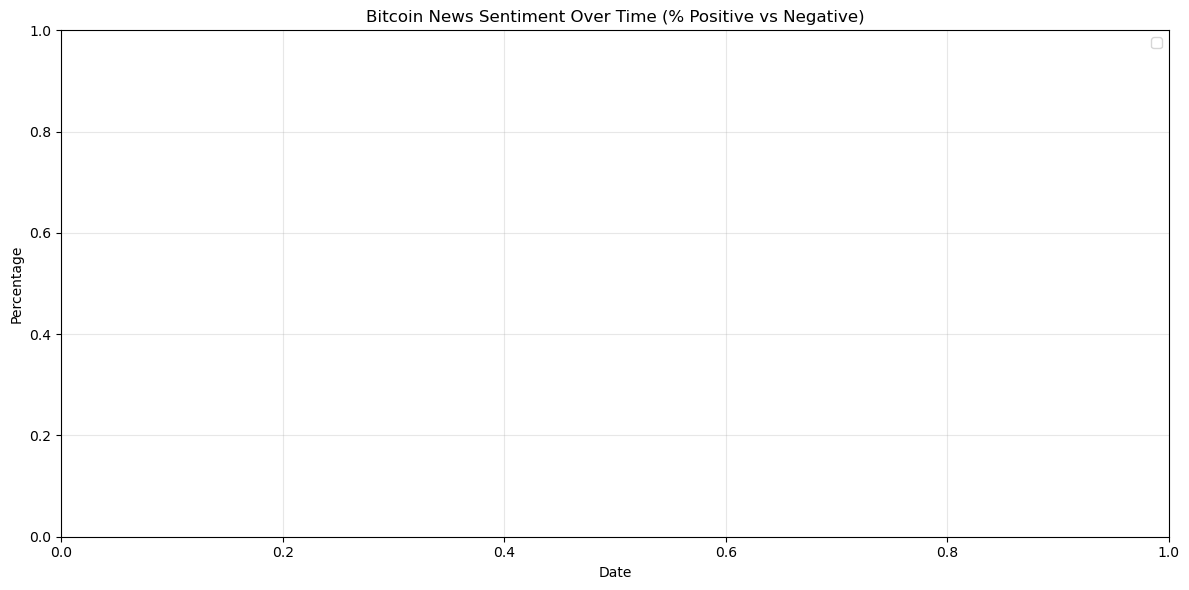

In [18]:
# Group by date and calculate sentiment percentages
df['date'] = df['publishedAt'].dt.date
sentiment_by_date = df.groupby('date')['sentiment'].value_counts().unstack().fillna(0)

# Calculate percentages
for col in sentiment_by_date.columns:
    sentiment_by_date[f'{col}_pct'] = sentiment_by_date[col] / sentiment_by_date.sum(axis=1) * 100

# Create figure
plt.figure(figsize=(12, 6))

# Plot percentage of positive and negative sentiment
if 'Positive' in sentiment_by_date.columns:
    plt.plot(sentiment_by_date.index, sentiment_by_date['Positive_pct'], 
             color='green', marker='o', linestyle='-', label='Positive %')
if 'Negative' in sentiment_by_date.columns:
    plt.plot(sentiment_by_date.index, sentiment_by_date['Negative_pct'], 
             color='red', marker='x', linestyle='-', label='Negative %')

plt.title('Bitcoin News Sentiment Over Time (% Positive vs Negative)')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.3 Rolling Average Sentiment Score

Let's calculate and visualize a 7-day rolling average of the sentiment score.

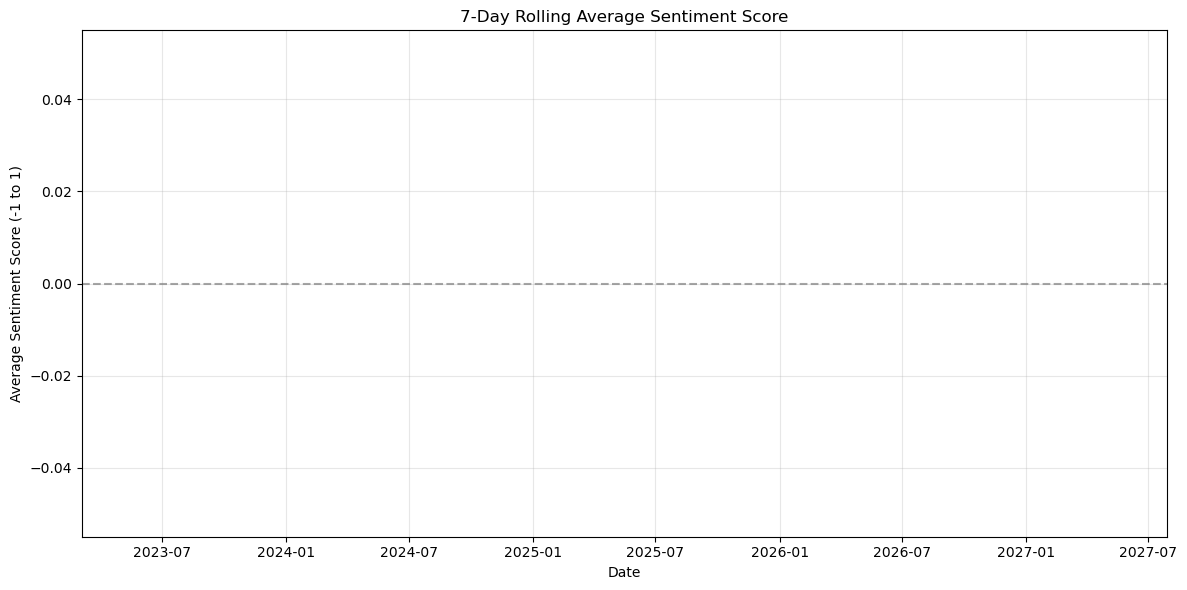

In [19]:
# Calculate rolling sentiment score (7-day window)
daily_score = df.groupby('date')['score'].mean()
rolling_score = daily_score.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(rolling_score.index, rolling_score, color='blue', linewidth=2)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.title('7-Day Rolling Average Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score (-1 to 1)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.4 Interactive Visualization with Plotly

Now let's create an interactive visualization using Plotly for better exploration.

In [20]:
# Create an interactive time series
fig = make_subplots(rows=2, cols=1, 
                   subplot_titles=('Sentiment Distribution Over Time', 'Rolling Average Sentiment Score'))

# Add sentiment distribution
for sentiment, color in zip(['Positive', 'Neutral', 'Negative'], ['green', 'gray', 'red']):
    if sentiment in sentiment_by_date.columns:
        fig.add_trace(
            go.Scatter(
                x=sentiment_by_date.index, 
                y=sentiment_by_date[f'{sentiment}_pct'],
                mode='lines+markers',
                name=f'{sentiment} %',
                line=dict(color=color),
                hovertemplate='%{y:.1f}%<extra></extra>'
            ),
            row=1, col=1
        )

# Add rolling sentiment score
fig.add_trace(
    go.Scatter(
        x=rolling_score.index,
        y=rolling_score,
        mode='lines',
        name='7-Day Avg Score',
        line=dict(color='royalblue', width=3),
        hovertemplate='Score: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Add horizontal line at y=0 for the second subplot
fig.add_shape(
    type='line',
    x0=rolling_score.index.min(),
    x1=rolling_score.index.max(),
    y0=0, y1=0,
    line=dict(color='gray', dash='dash'),
    row=2, col=1
)

# Update layout
fig.update_layout(
    title='Bitcoin News Sentiment Analysis',
    height=800,
    hovermode='x unified',
    showlegend=True,
)

fig.update_yaxes(title_text='Percentage', row=1, col=1)
fig.update_yaxes(title_text='Sentiment Score', row=2, col=1)

fig.show()

## 6. Examining Headlines by Sentiment

Let's look at examples of headlines for each sentiment category.

In [21]:
# Display examples of headlines by sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    headlines = df[df['sentiment'] == sentiment]['headline'].unique()[:3]
    print(f"\n{sentiment} Headlines:")
    for headline in headlines:
        print(f"  • {headline}")


Positive Headlines:

Neutral Headlines:

Negative Headlines:


## 7. Customizing for Different Cryptocurrencies

One of the strengths of this system is how easy it is to adapt for different cryptocurrencies. Let's demonstrate how to customize it for Ethereum.

In [22]:
def analyze_crypto_sentiment(crypto="Bitcoin", days_back=7, page_size=10, demo=DEMO_MODE):
    """Analyze news sentiment for different cryptocurrencies"""
    if not demo:
        # In a real implementation, you would modify the search query in fetch_bitcoin_news
        # Here's a simplified example (would need to be adjusted for the actual implementation)
        try:
            from bitcoin_utils import Config, process_news_articles
            
            config = Config.load()
            
            # This is a placeholder for how you might modify the function in a real implementation
            # In a complete implementation, you would modify the fetch_bitcoin_news function
            # to accept a query parameter or modify the process_news_articles function
            print(f"Fetching and analyzing {crypto} news...")
            print(f"In a real implementation, you would modify the API query from 'Bitcoin' to '{crypto}'")
            
            # Placeholder for actual API call
            print(f"This would call: process_news_articles(config, page_size={page_size}, days_back={days_back}, query='{crypto}')")
            
        except ImportError:
            print("Could not import bitcoin_utils. Using demo data instead.")
            demo = True
    
    if demo:
        # Create sample data for the specified crypto
        print(f"Creating sample data for {crypto}")
        sample_df = create_sample_data(days=days_back, ticker=crypto)
        
        # Save to CSV with crypto name
        crypto_lower = crypto.lower()
        csv_path = data_dir / f"{crypto_lower}_sentiment_results.csv"
        sample_df.to_csv(csv_path, index=False)
        print(f"Sample {crypto} data saved to {csv_path}")
        
        return sample_df
    
    return None  # In a real implementation, this would return the analyzed data

# Demo for Ethereum
ethereum_df = analyze_crypto_sentiment("Ethereum", days_back=14)

if ethereum_df is not None:
    # Quick visualization of Ethereum sentiment
    eth_sentiment_counts = ethereum_df['sentiment'].value_counts()
    
    # Create pie chart
    labels = eth_sentiment_counts.index
    values = eth_sentiment_counts.values
    colors = ['green' if x == 'Positive' else 'red' if x == 'Negative' else 'gray' for x in labels]
    
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3, marker_colors=colors)])
    fig.update_layout(title_text=f"Ethereum News Sentiment Distribution")
    fig.show()
    
    # Show example headlines
    print("\nSample Ethereum Headlines:")
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        headlines = ethereum_df[ethereum_df['sentiment'] == sentiment]['headline'].unique()[:2]
        print(f"\n{sentiment} Headlines:")
        for headline in headlines:
            print(f"  • {headline}")

Fetching and analyzing Ethereum news...
In a real implementation, you would modify the API query from 'Bitcoin' to 'Ethereum'
This would call: process_news_articles(config, page_size=10, days_back=14, query='Ethereum')


## 8. Conclusion

This notebook demonstrated a complete workflow for Bitcoin news sentiment analysis:

1. Setting up the environment and configuration
2. Fetching and analyzing news articles
3. Loading results from CSV
4. Creating visualizations of sentiment over time
5. Customizing the analysis for different cryptocurrencies

The modular design of the system makes it easy to:
- Schedule regular sentiment analysis updates
- Customize for different crypto assets
- Visualize the results in various formats
- Integrate with trading strategies or dashboards

For production use, you would typically set up this system to run on a schedule and feed into a dashboard or trading algorithm.